### 00_data_load

In [8]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

In [9]:
class CustomDataset(Dataset):
    
    def __init__(self, root, transformations = None):
        
        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*.jpg"))]
        
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1
        
    def get_class(self, path): return os.path.dirname(path).split("/")[-1]
    
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transformations is not None: im = self.transformations(im)
        
        return im, gt

In [ ]:
def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
    
    ds = CustomDataset(root = root, transformations = transformations)
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    
    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])
    
    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "data/Clothes_Dataset"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 64)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)


422
24
375
{'Clothes_Dataset\\Blazer': 0, 'Clothes_Dataset\\Celana_Panjang': 1, 'Clothes_Dataset\\Celana_Pendek': 2, 'Clothes_Dataset\\Gaun': 3, 'Clothes_Dataset\\Hoodie': 4, 'Clothes_Dataset\\Jaket': 5, 'Clothes_Dataset\\Jaket_Denim': 6, 'Clothes_Dataset\\Jaket_Olahraga': 7, 'Clothes_Dataset\\Jeans': 8, 'Clothes_Dataset\\Kaos': 9, 'Clothes_Dataset\\Kemeja': 10, 'Clothes_Dataset\\Mantel': 11, 'Clothes_Dataset\\Polo': 12, 'Clothes_Dataset\\Rok': 13, 'Clothes_Dataset\\Sweter': 14}


### 001_data_analysis

C:\Users\avnee\AppData\Local\Temp\ipykernel_1880\1630197044.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 60)


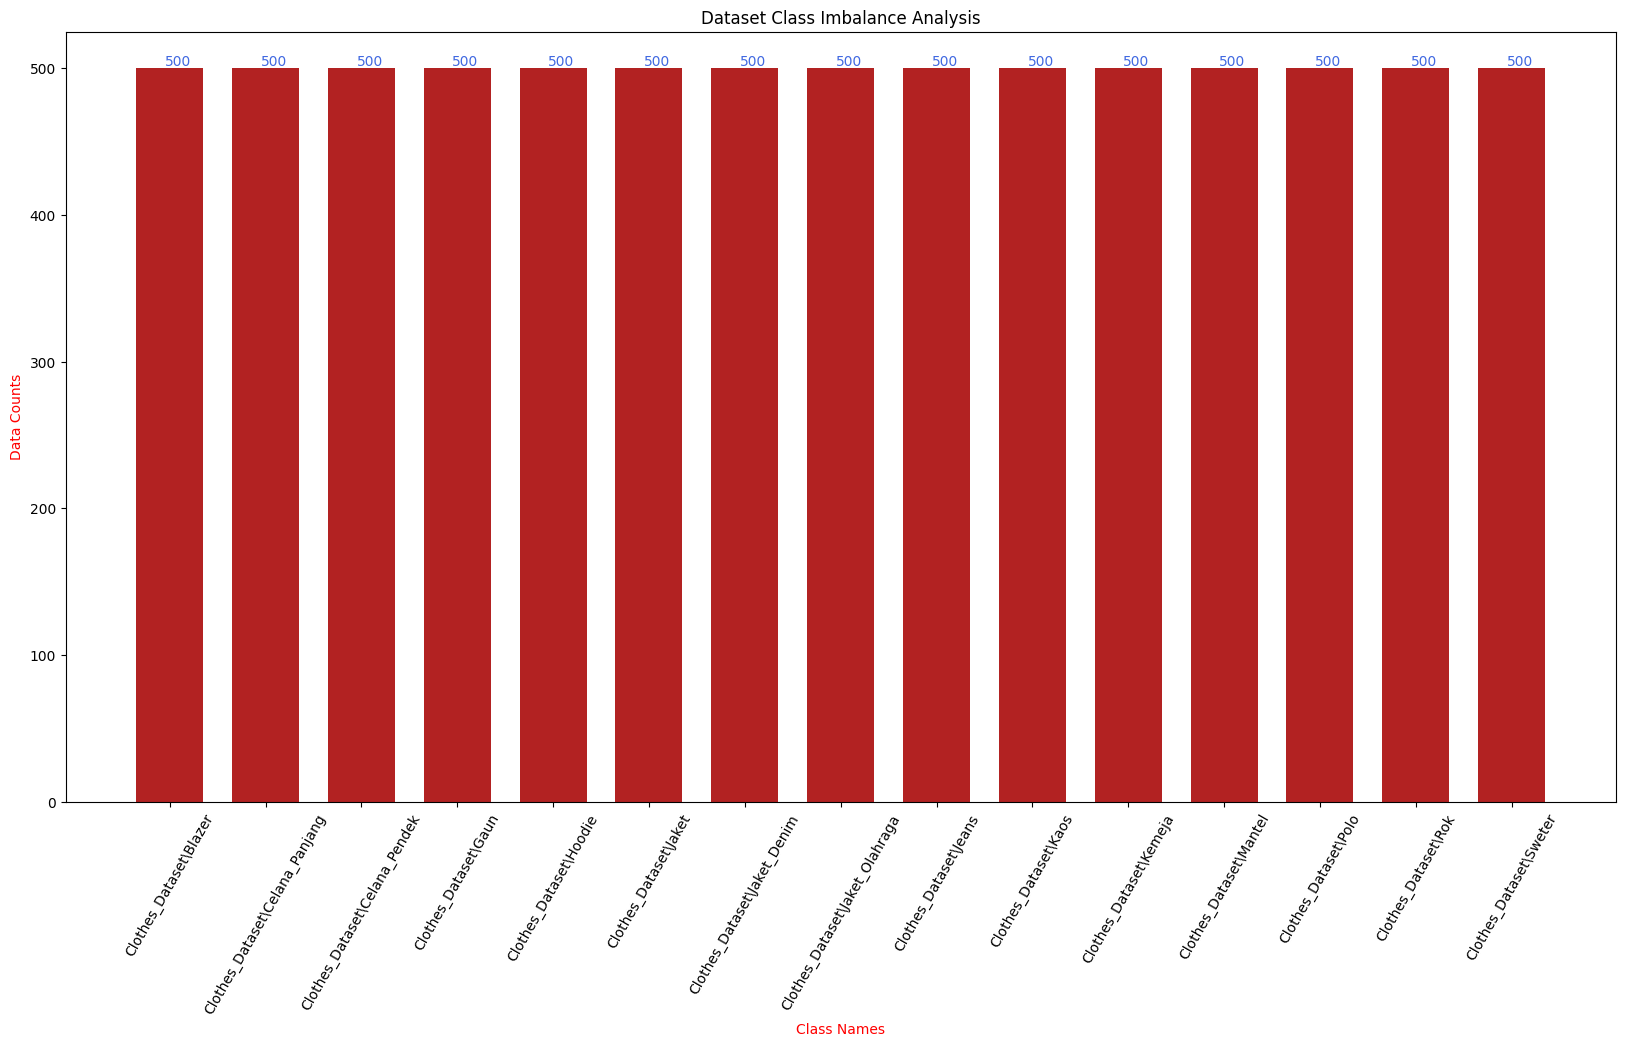

In [11]:
import random
from matplotlib import pyplot as plt

def data_analysis(root, transformations):
    
    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
data_analysis(root = root, transformations = tfs)

### data viz

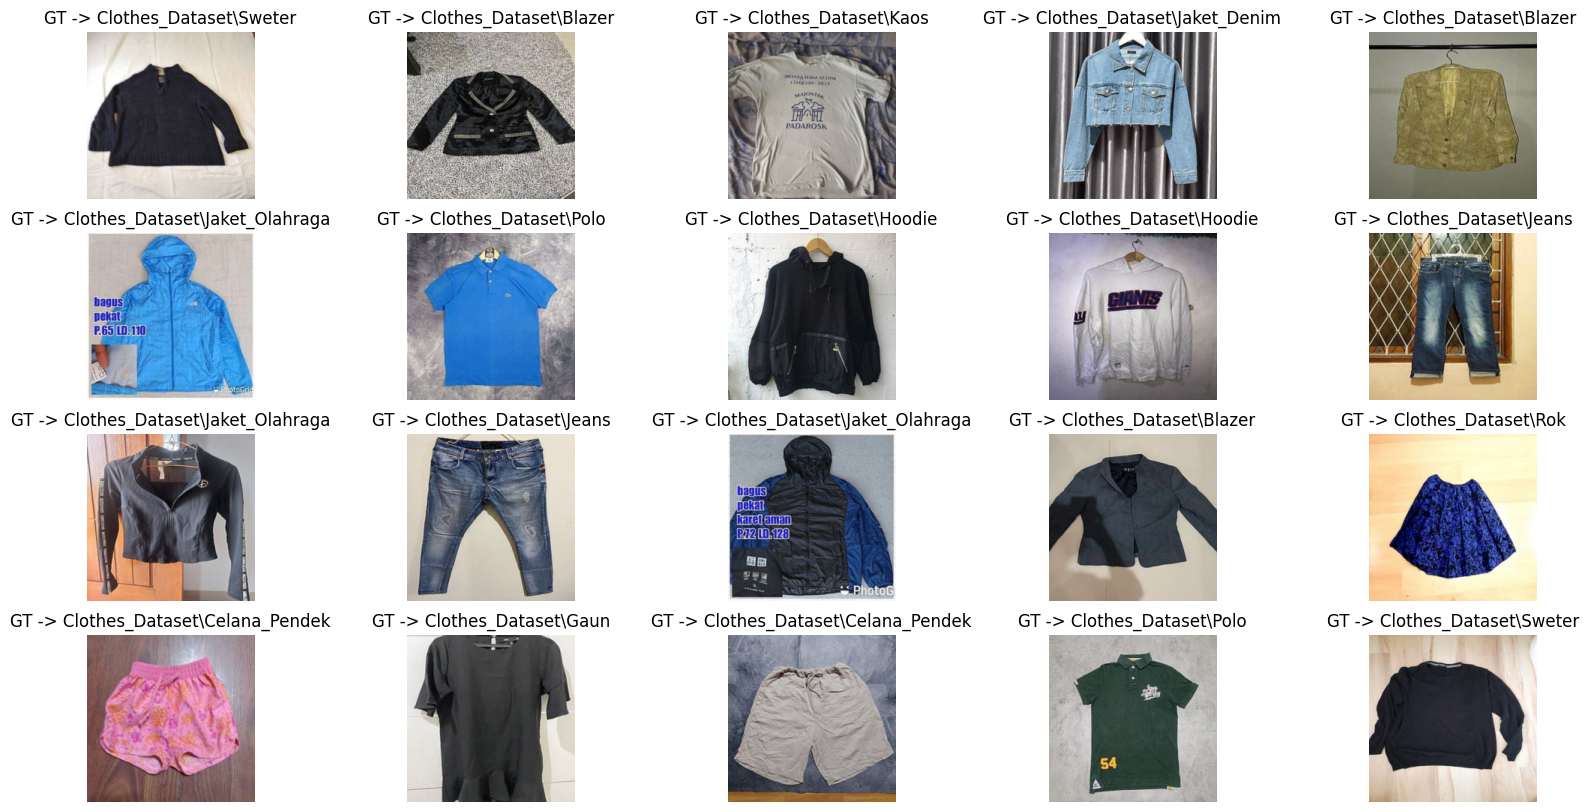

In [12]:
def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

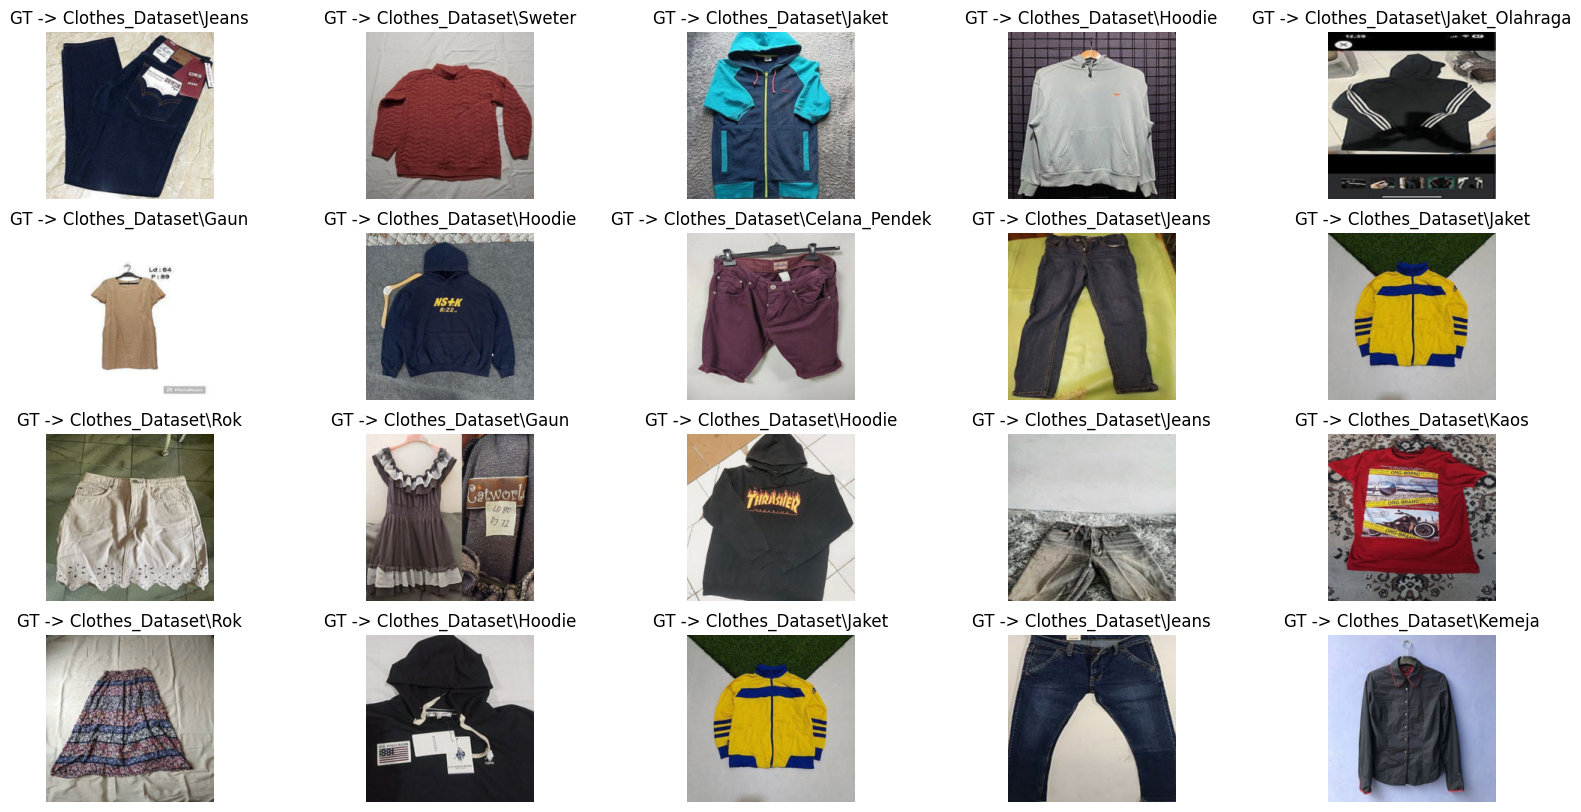

In [13]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

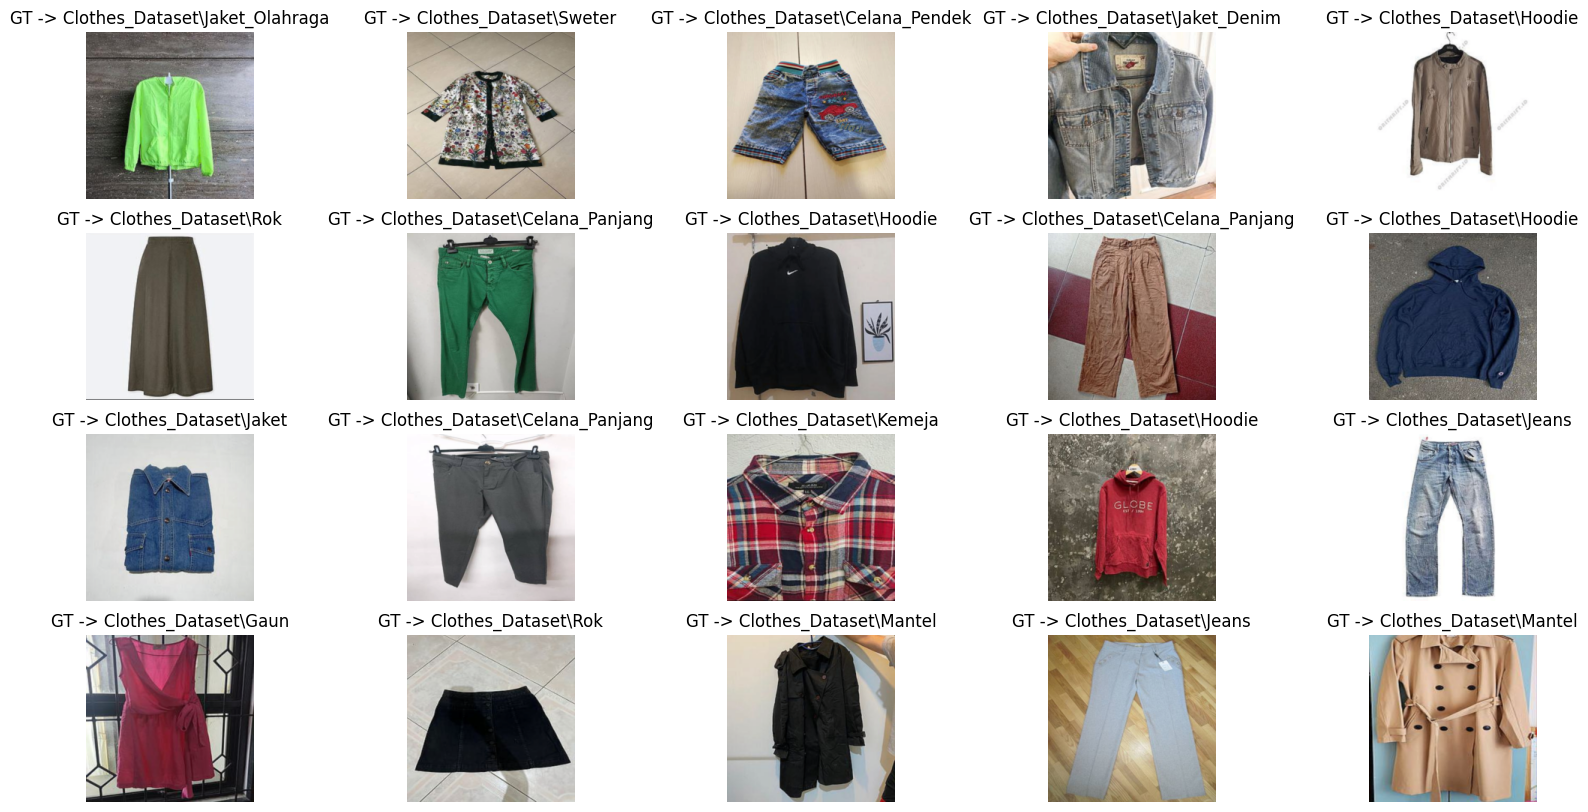

In [14]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

### AI training

In [7]:
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [9]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0))

CUDA Available: True
Device Name: NVIDIA GeForce GTX 1650


In [10]:
# ! pip install timm==0.9.2

In [11]:
# ! pip show torchmetrics

In [17]:
import timm
import torchmetrics
from tqdm.auto import tqdm

c:\Users\avnee\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))  

def train_setup(m): return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "leaf", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)
    
for epoch in tqdm(range(epochs)):
    # if epoch == 1: break

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):
        # if idx == 2: break

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            # if idx == 2: break
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break


Start training...


  0%|          | 0/10 [00:00<?, ?it/s]

### 05_learning curve

In [ ]:
class PlotLearningCurves:
    
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        
        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s
        
    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)
        
    def create_figure(self): plt.figure(figsize = (10, 5))
    
    def decorate(self, ylabel, xlabel = "Epochs"): 
        
        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()      
        
    def visualize(self):
        
        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")
        
        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")
        
        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")
        
PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()

### Inferrence

In [ ]:
! pip install grad-cam==1.4.6


In [ ]:
import cv2, seaborn as sns
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_value_array(logits, gt, cls_names):
    
    probs = torch.nn.functional.softmax(logits, dim = 1)
    pred_score, pred_class = torch.max(probs, dim = 1) 

    plt.grid(visible = True)
    plt.xticks(range(len(cls_names)), cls_names, rotation='vertical')
    plt.yticks(np.arange(start = 0., stop = 1.01, step = 0.1))
    bar = plt.bar(range(len(cls_names)), [p.item() for p in probs[0]], color="#777777")
    plt.ylim([0, 1])   
    # Color the bars based on the criteria
    bar[pred_class].set_color('green') if pred_class.item() == gt else bar[pred_class].set_color('red')

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):
    
    with torch.no_grad():
        preds, images, lbls, logitss = [], [], [], []
        acc, count                   = 0, 1
        for idx, batch in tqdm(enumerate(test_dl)):
            # if idx == num_ims: break
            im, gt = to_device(batch, device)
            logits  = model(im)
            pred_class   = torch.argmax(logits, dim = 1)
            acc += (pred_class == gt).sum().item()
            images.append(im)
            logitss.append(logits)
            preds.append(pred_class)
            lbls.append(gt.item())
        
        print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")
        
    plt.figure(figsize = (20, 10))
    cam = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]], use_cuda = False)
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im = tensor_2_im(images[indeks].squeeze())
        pred_idx = preds[indeks]
                
        # Start plot
        plt.subplot(row, 2 * num_ims // row, count); count += 1
        plt.imshow(im, cmap = "gray"); plt.axis("off")
        
        grayscale_cam = cam(input_tensor=images[indeks])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(im / 255, grayscale_cam, image_weight=0.4, use_rgb = True)
        plt.imshow(cv2.resize(visualization, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.7, cmap='jet'); plt.axis("off")
        plt.subplot(row, 2 * num_ims // row, count); count += 1
        plot_value_array(logits = logitss[indeks], gt = lbls[indeks], cls_names = cls_names)
        
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")        
    
    plt.figure(figsize = (20, 10))
    sns.heatmap(confusion_matrix([pred.detach().cpu().numpy() for pred in preds], lbls), annot=True, fmt='d', xticklabels=cls_names, yticklabels=cls_names)
    plt.title("Confusion Matrix")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 10, row = 2, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)
